<a href="https://colab.research.google.com/github/BeritKO/codelabs/blob/main/Bootcamp_2026_CNNs_Practical_(GdJ).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MuST Bootcamp 2026: Convolutional Neural Networks
(credit to Harmen Potgieter for the Colab script)

**Contents**


*   Basics of convolutions
*   How to train a simple CNN for image classification on CIFAR10 dataset
*   How to visualize feature maps and kernels
*   How to define a CNN from scratch and train it on the MNIST dataset
*   How to change the architecture of a CNN


# 1 Setup

*   The first step is to connect the session to hardware.
*   This is followed by downloading and importing the packages nessecary to handle each of the operations we will be doing in this practical.
*   Next we run some code in order to reproduce the results we obtain
*   The hyperparameters are set for the first code-blocks we will be executing
*   Lastly we will download the dataset which we will use for the first few exercises.

## 1.1 Colab environment setup

*   Select Runtime->Change runtime type
*   Select 'GPU' as a hardware accelerator if it is available.  
*   Check GPU availability by running the code cell below.

In [ ]:
! nvidia-smi

## 1.2 Imports

*   "torch" the main PyTorch library.
*   "torch.nn" the preconfigured PyTorch neural network building blocks that we need.
*   "torchvision" consists of popular datasets, model architectures, and common image transformations for computer vision.
*   "torchvision.transforms" the image transformations referred to above.
*   "numpy" - for mathematical operation on arrays.
*   "matplotlib.pyplot" - for plotting.
*   "torchinfo" - for visualizing model architecture.
*   "random" - for random number generation.

* Run the code cell below to install packages that are not available on Colab by default.

In [ ]:
! pip install torchinfo

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import copy
from torchvision.utils import make_grid
import torchinfo
from tqdm.notebook import tqdm
import random

## 1.3 Reproducibility

* Set seed for (pseudo) random number generators.


In [ ]:
seed = 24
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## 1.4 Hyperparameters



*   Set the prefered values of each hyperparameter for the dataset


In [ ]:
batch_size = 5 # The size of the mini-batches that the data set will be split up into
num_classes = 10 #The number of MNIST classes

## 1.5 Dataset

We are using the MNIST dataset: 60,000 28x28 images from 10 different classes.

Loading a train, validation, and test set in PyTorch is split into three steps:


1.   Grab the actual train and test data set from the torchvision library, which will download the dataset from a specified URL, and also transform the dataset from Numpy arrays to Torch tensors.
4.   Use a DataLoader to load these data sets for excercises.



In [ ]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../data/', # Where to store the dataset locally, or get it if it's already been downloaded.
                                           train=True, # Train=True means we are grabbing the train set of MNIST
                                           transform=transforms.ToTensor(), # Transform the numpy arrays to Torch Tensors and apply zero-one scaling
                                           download=True) # Data set will require downloading (we haven't downloaded it before))

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, # Specify the data set for the data loader
                                           batch_size=batch_size, # Set the batch size
                                           shuffle=True) # Shuffle the training examples

**Check the size of the train/validation/test data splits.**

In [ ]:
print('Training set size:\t', len(train_dataset))

**Visualize a few images from the dataset**

  


In [ ]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
n = 10
for i in range(1, n+1):
    plt.subplot(2, n//2,i)
    plt.axis('off')
    plt.imshow(train_dataset.data[i].reshape((28, 28)), cmap='gray')
    plt.title(class_names[int(train_dataset.targets[i])])
plt.tight_layout()
plt.show()
plt.close()

# 2 Visualising CNN operations


**Colormap:**

* We are using the "PiYG" colormap in pyplot.
* Dark pink corresponds small values.
* Dark Green corresponds to large values.





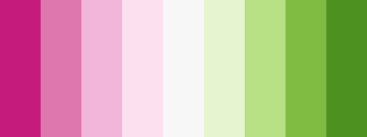

In [ ]:
# Assuming `train_dataset.data` is already a tensor
batch_images = train_dataset.data[:batch_size].clone().detach().float()  # Safely copy and cast to float
batch_images = batch_images.reshape(batch_size, 28, 28)  # Reshape to (batch_size, 28, 28)
batch_images = batch_images.unsqueeze(1)  # Add channel dimension
print(f'Size of input: {tuple(batch_images.shape)}')

# (batch, channels, height, width)

## 2.1 Convolutions

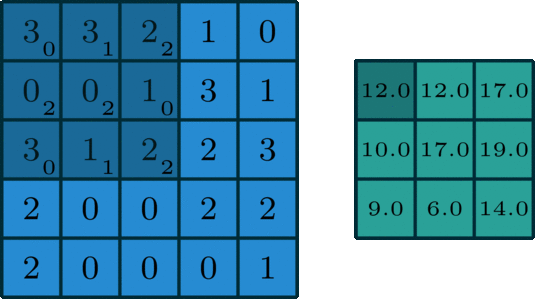



*   Function to perform the convolution of the selected kernel with the input image.
*   Function to plot the input and output.



In [ ]:
def convolution(image, kernel):
  convolved_image = torch.nn.functional.conv2d(image, kernel, padding='same')  # Padding ensures 'same' size

  return convolved_image.squeeze(0).squeeze(0).detach().numpy()

def plot_kernels(batch_size, batch_images, kernel, color):
  # Create the figure for displaying
  plt.figure()

  # Iterate through each image in the batch
  for i in range(batch_size):
      # Plot the original image on top row
      plt.subplot(2, batch_size, i + 1)
      plt.axis('off')
      input = batch_images[i, 0].detach().numpy()
      plt.imshow(input, cmap='grey')
      plt.title(f"Original {i+1} \n {tuple(input.shape)}")

      # Plot the convolved image on the bottom row
      plt.subplot(2, batch_size, i + batch_size + 1)
      plt.axis('off')
      out = convolution(batch_images[i], kernel)
      plt.imshow(out, cmap=color)
      plt.title(f"Out {i+1} \n {tuple(out.shape)}")

  # Adjust space between subplots
  plt.subplots_adjust(hspace=0.1, wspace=0.1)  # Adjust vertical and horizontal spacing
  plt.tight_layout()

  plt.show()

**1) Vertical Edge Kernel**

In [ ]:
vertical_lines_kernel = np.array([[1, 0, -1],
                                  [1, 0, -1],
                                  [1, 0, -1]])
plt.figure()
plt.imshow(vertical_lines_kernel, cmap='grey')
plt.show()

kernel_vertical = torch.tensor(vertical_lines_kernel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape (1, 1, 3, 3)

plot_kernels(batch_size, batch_images, kernel_vertical, 'PiYG')

**2) Horizontal Edge Kernel**

In [ ]:
horizontal_lines_kernel = np.array([[-1, -1, -1],
                                    [0, 0, 0],
                                    [1, 1, 1]])
plt.figure()
plt.imshow(horizontal_lines_kernel, cmap='grey')
plt.show()

kernel_horizontal = torch.tensor(horizontal_lines_kernel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

plot_kernels(batch_size, batch_images, kernel_horizontal, 'PiYG')

**3) Edge Detection Kernel**

In [ ]:
edge_kernel = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
plt.figure()
plt.imshow(edge_kernel, cmap='grey')
plt.show()

kernel_edge = torch.tensor(edge_kernel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

plot_kernels(batch_size, batch_images, kernel_edge, 'PiYG')

**4) Blurring Kernel**

In [ ]:
blur_kernel = np.array([[1, 0, 1],
                        [0, 1, 0],
                        [1, 0, 1]])
plt.figure()
plt.imshow(blur_kernel, cmap='grey')
plt.show()

kernel_blur = torch.tensor(blur_kernel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

plot_kernels(batch_size, batch_images, kernel_blur, 'grey')

**5) Sharpening Kernel**

In [ ]:
sharpening_kernel = np.array([[0, -1, 0],
                              [-1, 5, -1],
                              [0, -1, 0]])
plt.figure()
plt.imshow(sharpening_kernel, cmap='grey')
plt.show()

kernel_sharpening = torch.tensor(sharpening_kernel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

plot_kernels(batch_size, batch_images, kernel_sharpening, 'grey')

## 2.2 Kernel Size

**Plot the output of a convolution with different sized kernels**
*     Function to generate different sized kernels
*     Function to perform convolution
*     Function to visualise the different sized kernels outputs

In [ ]:
def generate_kernel(max_size):
    """Generates kernels dynamically up to max_size with step 2."""
    base_kernel = np.array([[1, 2, 1],
                            [2, 4, 2],
                            [1, 2, 1]], dtype=np.float32) # Blurring kernel
    kernels = []
    current_kernel = base_kernel
    while current_kernel.shape[0] <= max_size:
        kernels.append(current_kernel)
        current_kernel = np.pad(current_kernel, pad_width=1, mode='constant', constant_values=1)
    return kernels

def convolution(image, kernel):

  convolved_image = torch.nn.functional.conv2d(image, kernel, padding=0)

  return convolved_image.squeeze(0).squeeze(0).detach().numpy()

def apply_and_visualize_kernels(image, kernels):
    """Apply kernels to an image and display results with corresponding kernel heatmaps."""
    num_kernels = len(kernels)
    plt.figure(figsize=(8, num_kernels * 3))

    for i, kernel in enumerate(kernels):
        # Convolution (replace `convolution` with your function if necessary)
        kernel_torch = torch.tensor(kernel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        convolved_image = convolution(image, kernel_torch)

        # Plot the kernel as a heatmap
        plt.subplot(num_kernels, 2, 2 * i + 1)
        plt.imshow(kernel, cmap='grey', interpolation='nearest')
        plt.title(f"Kernel {kernel.shape[0]}x{kernel.shape[1]}")
        plt.colorbar(label="Kernel Value")
        plt.axis('off')

        # Plot the convolved image
        plt.subplot(num_kernels, 2, 2 * i + 2)
        plt.imshow(convolved_image, cmap='gray')
        plt.title(f"Output size: {convolved_image.shape}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
kernels = generate_kernel(11)  # Generate kernels from 3x3 to 7x7
apply_and_visualize_kernels(batch_images[0], kernels)  # Apply and visualize

## 2.3 Stride

**Plot outputs of convolutions with kernels using different strides**
*     Function to perform convolution
*     Function to use different stride values and to plot the results

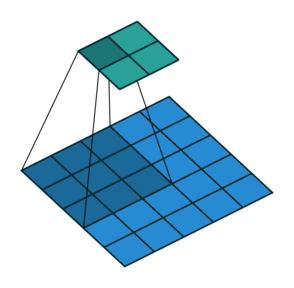

In [ ]:
def convolution(image, kernel, stride_amount):
  convolved_image = torch.nn.functional.conv2d(image, kernel, stride=stride_amount, padding=0)

  return convolved_image.squeeze(0).squeeze(0).detach().numpy()

def loop_stride(stride_max, image_num):

  blur_kernel = np.array([[1, 2, 1],
                          [2, 4, 2],
                          [1, 2, 1]]) # Blurring kernel
  kernel = torch.tensor(blur_kernel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

  plt.figure(figsize=(15, 5))
  image = batch_images[image_num]

  for i in range(1, stride_max+1):
      # Plot the image on top row
      plt.subplot(2, batch_size, i)
      plt.axis('off')
      output = convolution(image, kernel, i)
      plt.imshow(output, cmap='gray')
      plt.title(f"Stride {i} \n {tuple(output.shape)}")

  # Adjust space between subplots
  plt.subplots_adjust(hspace=0.3, wspace=0.1)
  plt.tight_layout()
  plt.show()

**Run stride test**

In [ ]:
sample_num = 4      # choose sample image (0:4)
stride_amount = 10  # choose stride
loop_stride(stride_amount, sample_num)

## 2.4 Padding
**Perform convolutions with differnet sized padded inputs**
*     Function to perform the convoltion
*     Function to plot the outputs of different padded inputs

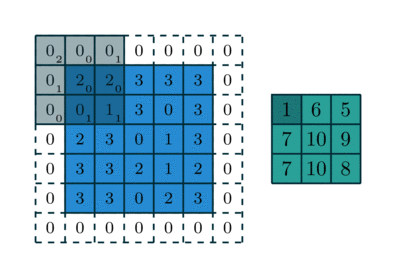
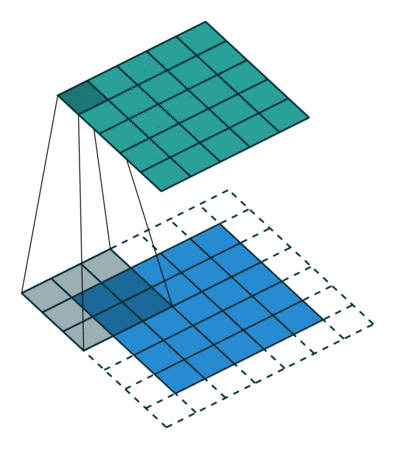

In [ ]:
def convolution(image, kernel, padding_amount):
  convolved_image = torch.nn.functional.conv2d(image, kernel, padding=padding_amount)

  return convolved_image.squeeze(0).squeeze(0).detach().numpy()

def loop_padding(padding, image_num):

  kernel = np.array([[1, 2, 1],
                     [2, 4, 2],
                     [1, 2, 1]])
  kernel = torch.tensor(kernel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape (1, 1, 3, 3)

  plt.figure(figsize=(15,5))
  image = batch_images[image_num]

  plt.subplot(2, batch_size+1, 1)
  plt.axis('off')
  plt.imshow(image.squeeze(0), cmap='gray')
  plt.title(f"Original \n {tuple(image.shape[1:])}")
  plt.xlabel(str(image.shape))

  plt.subplot(2, batch_size+1, 2)
  plt.axis('off')
  plt.imshow(convolution(image, kernel, 'same'), cmap='gray')
  plt.title(f"Pad same \n {tuple(image.shape[1:])}")
  plt.xlabel(str(image.shape))

  for i in range(padding):

      # Plot the image on top row
      plt.subplot(2, batch_size+1, i + 3)
      plt.axis('off')
      output = convolution(image, kernel, i)
      plt.imshow(output, cmap='gray')
      plt.title(f"Pad {i} \n In: {tuple(image.shape[1:])} \n Out:{tuple(output.shape)}") #fix size {tuple(x + i for x in tuple(image.shape[1:]))}

  # Adjust space between subplots
  plt.subplots_adjust(hspace=0.4, wspace=0.1)  # Adjust vertical and horizontal spacing
  plt.tight_layout()

  plt.show()

In [ ]:
sample_num = 1 # (0:4)
padding_num = 10
loop_padding(padding_num, sample_num)

## 2.5 Dilation
**Peform convolutions with different dilation values**
*     Function to perform the convolution
*     Function to plot the results

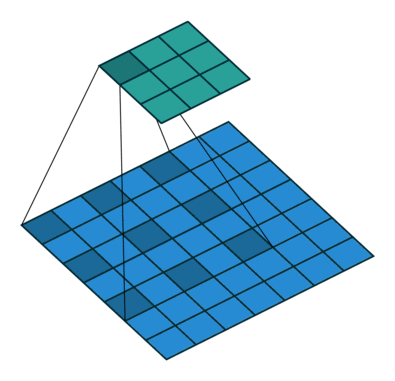
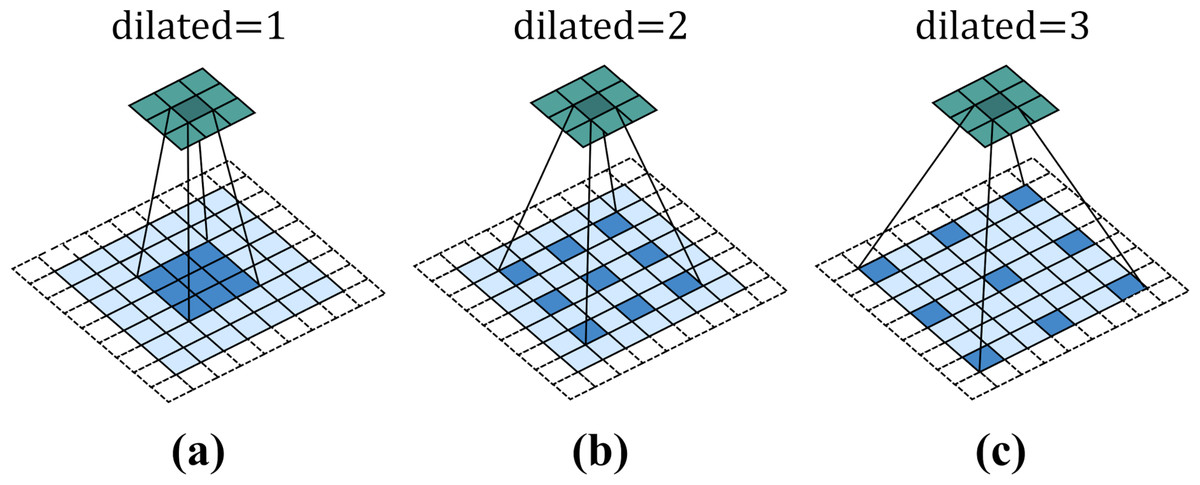

In [ ]:
def dilate(image, dilation_amount):

  kernel = np.array([[0, 1, 0],
                     [1, 2, 1],
                     [0, 1, 0]])
  kernel = torch.tensor(kernel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
  convolved_image = torch.nn.functional.conv2d(image, kernel, padding=0, dilation=dilation_amount)

  plt.figure(figsize=(15, 5))
  plt.subplot(1, 2, 1)
  plt.title(f'Input Image \n Size: {tuple(image.shape[1:])}')
  plt.imshow(image.squeeze(0).squeeze(0).detach().numpy(), cmap='gray')

  plt.subplot(1, 2, 2)
  plt.title(f'Output Image \n Size: {tuple(convolved_image.shape[1:])}')
  plt.imshow(convolved_image.squeeze(0).squeeze(0).detach().numpy(), cmap='gray')

  plt.tight_layout()
  plt.show()

In [ ]:
image_num = 0
dilation = 3

dilate(batch_images[image_num], dilation)

## 2.6 Pooling
**Perform max pooling and average pooling on the input**
*     Function to perform the pooling operations

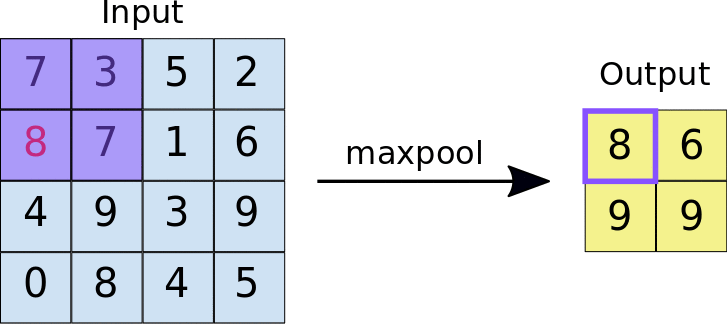
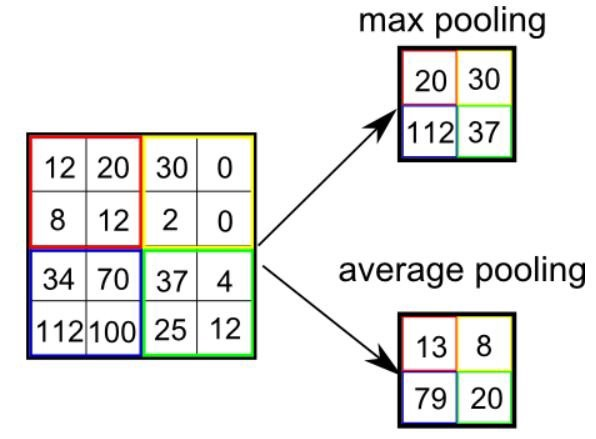

In [ ]:
def pooling_operations(image, kernel_size, stride_amount):

  # Define pooling layers
  max_pool = nn.MaxPool2d(kernel_size=kernel_size, stride=stride_amount)
  average_pool = nn.AvgPool2d(kernel_size=kernel_size, stride=stride_amount)

  # Perform pooling
  max_pooled_output = max_pool(image)
  average_pooled_output = average_pool(image)

  # Remove batch and channel dimensions for easier visualization
  max_pooled_output = max_pooled_output.squeeze(0).squeeze(0).detach().numpy()
  average_pooled_output = average_pooled_output.squeeze(0).squeeze(0).detach().numpy()

  # Plot the input and outputs
  plt.figure(figsize=(15, 5))

  plt.subplot(1, 3, 1)
  plt.title(f'Input Image \n {tuple(image.shape[2:])}')
  plt.imshow(image.squeeze(0).squeeze(0).detach().numpy(), cmap='PiYG', vmin=0, vmax=10)
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.title(f'Max Pooled Output \n {tuple(max_pooled_output.shape)}')
  plt.imshow(max_pooled_output, cmap='PiYG', vmin=0, vmax=10)
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.title(f'Average Pooled Output \n {tuple(average_pooled_output.shape)}')
  plt.imshow(average_pooled_output, cmap='PiYG', vmin=0, vmax=10)
  plt.axis('off')

  plt.show()

In [ ]:
kernel_size = 2
stride_amount = 2

matrix = np.random.rand(10,10) * 10
matrix = torch.tensor(matrix, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
pooling_operations(matrix, kernel_size, stride_amount)

## 2.7 Sandbox

Here is a place to practice what you learned and play around with the values of the hyperparameters to produce different outputs.

In [ ]:
def convolution_sandbox(image, kernel, stride_amount, padding_amount, dilation_amount):
  convolved_image = torch.nn.functional.conv2d(image, kernel, stride=stride_amount, padding=padding_amount, dilation=dilation_amount)

  plt.figure(figsize=(15, 5))

  plt.subplot(1, 2, 1)
  plt.title(f'Input Image \n Size: {tuple(image.shape[1:])}')
  plt.imshow(image.squeeze(0).squeeze(0).detach().numpy(), cmap='gray')

  plt.subplot(1, 2, 2)
  plt.title(f'Convolved Image \n Size: {tuple(convolved_image.shape[1:])}')
  plt.imshow(convolved_image.squeeze(0).squeeze(0).detach().numpy(), cmap='gray')


  plt.tight_layout()
  plt.show()

 Set hyper parameters
 [Pytorch conv2d documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

In [ ]:
kernel = np.array([[0, 0, 0],
                   [0, 1, 0],
                   [0, 0, 0]])

stride_amount = 1 # > 0
padding_amount = 0 # 'same' if stride 1, 0:
dilation_amount = 1 # > 0

image_num = 0

kernel = torch.tensor(kernel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
convolution_sandbox(batch_images[image_num], kernel, stride_amount, padding_amount, dilation_amount)

# 3 Training a CNN

*   We'll setup a simple model which takes the 32x32x3 CIFAR10 images as input, passes them to three convolutional layers, and outputs a vector of class scores for the 10 object categories.
*   As activation function, we'll use the Rectified Linear Unit (ReLU).

## 3.1 Hyperparameters
**Set each of the hyperparameters we will use during training**

In [ ]:
batch_size = 128                  # The size of the mini-batches that the data set will be split up into
validation_set_ratio = 0.2        # Reserve 20% of the training set for validation
max_epochs = 10                   # Maximum number of epochs to train the network for
learning_rate = 0.0005            # The step-size multiplier for each optimization step
num_classes = 10                  # The number of CIFAR10 classes
fully_connected_units = 64        # The number of neurons in the fully connected layer of the ConvNet
model_path_torch = './model.pth'  # Where to save the model

## 3.2 Dataset
**Download the datatset and split into train\val\test sets**


In [ ]:
# CIFAR10 dataset
train_val_dataset = torchvision.datasets.CIFAR10(root='../data/',           # Where to store the dataset locally, or get it if it's already been downloaded.
                                           train=True,                      # Train=True means we are grabbing the train set of CIFAR10
                                           transform=transforms.ToTensor(), # Transform the numpy arrays to Torch Tensors and apply zero-one scaling
                                           download=True)                   # Data set will require downloading (we haven't downloaded it before)

test_dataset = torchvision.datasets.CIFAR10(root='../data/',
                                          train=False,                      # Train=False means we are grabbing the test set
                                          transform=transforms.ToTensor())



# Split the training set

val_set_size = int(validation_set_ratio * len(train_val_dataset))
train_set_size = len(train_val_dataset) - val_set_size
generator = torch.Generator().manual_seed(seed)
train_dataset, validation_dataset = torch.utils.data.random_split(train_val_dataset,
                                          [train_set_size, val_set_size],
                                          generator=generator)


# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,           # Specify the data set for the data loader
                                           batch_size=batch_size,           # Set the batch size
                                           shuffle=True)                    # Shuffle the training examples

val_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)                   # No need to shuffle the validation set, we only use it for validation!

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)                    # No need to shuffle the test set, we only use it for evaluation!

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(validation_dataset)}")
print(f"Test set size: {len(test_dataset)}")

In [ ]:
class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
n = 10
for i in range(1, n+1):
    plt.subplot(2, n//2,i)
    plt.axis('off')
    plt.imshow(train_val_dataset.data[i].reshape((32, 32,3)))
    plt.title(class_names[int(train_val_dataset.targets[i])])
plt.tight_layout()
plt.show()
plt.close()

## 3.3 Defining the model

**Create dummy model**


*   The output channels of a layer needs to correspond with the input channels of the next layer.
*   Since we are using a fully connected layer, we need to flatten the output of the last convolutional layers.
* To calculate the input to the fully connected layer, we create a model without the fully connected layers.
* By using a single sample we can caluculate the flattened output size of the final convolutional layer.
* This variable is then used to define the model we will be using.

(If this feels 'janky', don't worry it is used all over by even some of the large ML libraries)



In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Define layers
        # Conv 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding="same")  # Define the convolutional layer with it's hyperparameters
        self.relu1 = nn.ReLU()                                                                           # Add the activation function
#       self.bn1 = nn.BatchNorm2d(num_features=16)                                                       # A BatchNorm layer will be added here, it only has a input features as the output features are the same as the input
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)                                               # Add a pooling layer

        # Conv 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding="same")
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="same")
        self.relu3 = nn.ReLU()

        # Conv 4
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding="same")
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected 1
        # ...


    def forward(self, inputs):
        # Define the forward pass
        x = self.conv1(inputs)
        x = self.relu1(x)
#       x = self.bn1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        x = x.reshape(x.size(0), -1)

        # Fully connected
        # ...

        return x.shape[1]

**Calculate fully connected input**
* This code block is used to create a new dataloader with a batch size of 1.
* The dummy model is then created. (Since we only use one sample it is not necessary to send both sample and model to the GPU for computation)
* It is not necessary to calculate the gradient since we are only interested in the output size of the final convolutional layer.

In [ ]:
new_dataloader = torch.utils.data.DataLoader(
    dataset=train_loader.dataset,                   # Use the same dataset
    batch_size=1,                                   # Set batch size to 1
)

# Create an iterator from the DataLoader
it = iter(new_dataloader)

# Get the next sample (image and label)
sample, label = next(it)

#Create Model
model = ConvNet()

# Run a forward pass with no gradient computation (for inference)
with torch.no_grad():
    fully_connected_input = model(sample)

print(f' Size of the flattened output of the final convolutional layer {fully_connected_input}')

**Create Model**
* Finaly we define the correct model that we will use.
* This is the same as the dummy model but with the addition of the fully connected layers.

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Define layers
        # Conv 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding="same")
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding="same")
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="same")
        self.relu3 = nn.ReLU()

        # Conv 4
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding="same")
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected 1
        self.fc5 = nn.Linear(fully_connected_input, fully_connected_units)
        self.relu5 = nn.ReLU()

        # Output
        self.fc6 = nn.Linear(fully_connected_units, num_classes)


    def forward(self, inputs):
        # Define the forward pass
        x = self.conv1(inputs)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        x = x.reshape(x.size(0), -1)
        x = self.fc5(x)
        x = self.relu5(x)
        outputs = self.fc6(x)

        return outputs

**Instantiate the model and place it on the device available: GPU or CPU**

In [ ]:
model = ConvNet()
print(torchinfo.summary(model, input_size=(batch_size, 3, 32, 32)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # Set the device which will be used
print("Device:", device)

model = ConvNet().to(device)                                            # Create an instance of the model and place it on the availabe device

## 3.4 Loss function and optimizer

**This enables the model to learn**

In [ ]:
criterion = nn.CrossEntropyLoss()                                     # Select cross entropy loss as loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    # Select adam as optimizer, and assign the learning rate and model

## 3.5 Training and evaluation
**Define a helper function for plotting training curves**

In [ ]:
def plot_training_curves(train_loss, val_loss, train_accuracy, val_accuracy):
  epochs = range(1, len(train_accuracy)+1, 1)

  plt.subplot(2,1,1)
  plt.title("Training curves")
  plt.plot(epochs, train_loss)
  plt.plot(epochs, val_loss)
  plt.ylabel('Loss')
  plt.legend(['Train loss', 'Validation loss'])
  plt.grid()

  plt.subplot(2,1,2)
  plt.plot(epochs, train_accuracy)
  plt.plot(epochs, val_accuracy)
  plt.ylabel('Accuracy [%]')
  plt.legend(['Train accuracy', 'Validation accuracy'])
  plt.xlabel("Epochs")
  plt.grid()

**Define a helper function for performance evaluation**

In [ ]:
def evaluate_performance(data_set_loader, model, loss_func):

  per_batch_loss = []                               # Empty list to store loss of each batch
  model.eval()                                      # Disable things such as batchnorm and droupout layers during evaluation
  with torch.no_grad():                             # Doesn't store the gradients of activations passed through the model, speeds up computation
    correct = 0
    total = 0
    for images, labels in tqdm(data_set_loader):    # Iterate through the data loader
      images = images.to(device)                    # Move each image to the appropriate device (if using GPU, this would move the batch of images to the VRAM)
      labels = labels.to(device)                    # Same as above for labels
      outputs = model(images)                       # Pass the images through the model
      _, predicted = torch.max(outputs.data, 1)     # Take the highest prediction from the model for each sample
      total += labels.size(0)
      correct += (predicted == labels).sum().item() # See how many of the predictions match the actual label
      loss = loss_func(outputs, labels)             # Calculate the loss between the predictions and true values
      per_batch_loss.append(float(loss) * labels.size(0)) # Add this batch's loss to the list
  epoch_loss = sum(per_batch_loss) / total          # Get the average loss for the epoch
  accuracy = 100 * (correct/total)                  # Calculate the accuracy
  return accuracy, epoch_loss

**Model training**


*   We'll write a training loop that trains the model for a set numbers of epochs, after each epoch the model is evaluated on the train and validation set.





In [ ]:
def train_model(model, num_epochs):
  train_loss_list = []
  val_loss_list = []
  train_accuracy_list = []
  val_accuracy_list = []

  best_valid_accuracy = 0
  best_epoch = 0
  best_epoch_train_accuracy = 0
  total_step = len(train_loader)

  for epoch in range(num_epochs):

    model.train()
    print('Epoch ' + str(epoch+1))
    for i, (images, labels) in tqdm(enumerate(train_loader)): # Iterate over batches

      images = images.to(device)                          # Move each image to the appropriate device (if using GPU, this would move the batch of images to the VRAM)
      labels = labels.to(device)                          # Same as above for labels

      optimizer.zero_grad() # Reset the gradient of each parameter to zero

      # Forward pass
      outputs = model(images)                             # Pass the samples through the model
      loss = criterion(outputs, labels)                   # Calculate the loss

      # Backward and optimize
      loss.backward() # Backpropagate, calculate the gradients
      optimizer.step() # Update parameters using gradients with optimizer (ADAM in this case)

    train_accuracy, train_loss = evaluate_performance(train_loader, model, criterion) # Test the model on the training set
    print('Train Accuracy: {}%'.format(train_accuracy))
    print('Train Loss: {}'.format(train_loss))
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    validation_accuracy, validation_loss = evaluate_performance(val_loader, model, criterion) # Test the model on the validation set
    print('Validation Accuracy: {}%'.format(validation_accuracy))
    print('Validation Loss: {}'.format(validation_loss))
    print('\n')
    val_loss_list.append(validation_loss)
    val_accuracy_list.append(validation_accuracy)

    if (validation_accuracy>best_valid_accuracy): # Save the model at this epoch if it has performed better
      best_valid_accuracy = validation_accuracy
      best_epoch = epoch+1
      best_epoch_train_accuracy = train_accuracy
      torch.save(model.state_dict(), model_path_torch) # Save the model state to the specified path

  print('Best model at Epoch ' + str(best_epoch))
  print('Train Accuracy: ' + str(best_epoch_train_accuracy) + '%')
  print('Validation Accuracy: ' + str(best_valid_accuracy) + '%')

  return train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list


# Train the model
train_loss, val_loss, train_accuracy, val_accuracy = train_model(model, max_epochs)

# Plot training curves
plot_training_curves(train_loss, val_loss, train_accuracy, val_accuracy)

**Model evaluation**

* Restore the best model after training.
* Evaluate the model on the test set.


In [ ]:
# After training, test the best model on the test set
model.load_state_dict(torch.load(model_path_torch, weights_only=False)) # Load the best model
test_accuracy, _ = evaluate_performance(test_loader, model, criterion)  # Test model on test set
print('Evaluation Accuracy: ' + str(test_accuracy) + '%')

# 4 Visualization of CNN kernels and feature maps
**This section is done for interest's sake**
* You are not required to know how each of the blocks of code work or have an explicit reason to perform any of these calculations for normal DL applications
* We are doing these steps so that you can visually see firstly the kernels that the model 'learned', and secondly how the input image is transformed by these kernels.

## 4.1 Convolution kernels
**It is not necessary to fully understand this code**
* This is a function to plot the weights of a layers kernels

In [ ]:
def visualize_kernel(map, channel=0):
    map -= map.min()
    map /= map.max()
    n,c,w,h = map.shape
    map = map[:,channel,:,:]                  # Extract one channel from the tensor to obtain a 3D tensor: n x w x h
    plt.figure(figsize=(20, 20))
    for i in range(n):
      plt.subplot(8, 8, i+1)
      plt.imshow(map[i], cmap="PiYG")
      plt.axis("off")


In [ ]:
# Visualize one channel of each convolution filter in a given layer
with torch.no_grad():                         # Context manager that tells PyTorch we don't need gradients for the following operations
  kernels = model.conv2.weight.cpu().numpy()  # Grab the weights of the Conv2 kernels
  visualize_kernel(kernels, channel=1)
  plt.axis('off')
  plt.ioff()
  plt.show()
  plt.close()

## 4.2 Resulting feature maps
**It is not necessary to fully understand this code**
* We again create a new data loader with a batch size of 1

In [ ]:
# Change the dataloader to have a batch_size of 1
new_dataloader = torch.utils.data.DataLoader(
    dataset=train_loader.dataset,  # Use the same dataset
    batch_size=1,                 # Set batch size to 1
)

**Record activation values of Layers**
* This is some fancy code that records the featuremap values (activation values) as each sample is passed through the model.

In [ ]:
activations = {}
def get_activation(name):
    # the hook signature
    def hook(model, input, output):
        activations[name] = output

    return hook

model.pool1.register_forward_hook(get_activation('layer_1'))
model.pool2.register_forward_hook(get_activation('layer_2'))
model.relu3.register_forward_hook(get_activation("layer_3"))
model.relu4.register_forward_hook(get_activation("layer_4"))


**Infer one sample through to record activations**

In [ ]:
# Itterate through the data_loader
it = iter(new_dataloader)
# Get next sample
sample, label = next(it)
image = sample.to(device)

# Run forward pass on the image
with torch.no_grad():
  preds = model(image)

original_image = torch.squeeze(image.cpu()).numpy()
original_image = original_image.transpose((1,2,0))  # Make image channel last
plt.imshow(original_image)
plt.title(f"Input image: {class_names[label]}")
plt.show()


**Retrieve the specific layer activations and display**

In [ ]:
# Get the featuremaps
feature_maps = activations['layer_1'].cpu().detach().numpy()  # The activations are stored in a array and each layers activation values can be retrieved by specifying the layer
feature_maps = feature_maps / feature_maps.max()

# Plot the feature maps
plt.figure(figsize=(20, 20))
print(feature_maps.shape)
for i in range(feature_maps.shape[1]):
    plt.subplot(8, 8, i+1)
    plt.imshow(feature_maps[0, i], cmap='jet')
    plt.axis('off')
plt.show()

**Display the classification propabilities and the input image**

In [ ]:
probabilities = F.softmax(preds.cpu(), dim=-1).numpy()[0]
plt.figure(figsize=(12, 6))

# Subplot 1: Bar chart for class probabilities
plt.subplot(1, 2, 1)
plt.bar(class_names, probabilities)
plt.xticks(rotation=45, ha="right")  # Rotate class names for better visibility
plt.title("Class Probabilities")
plt.xlabel("Classes")
plt.ylabel("Probability")

# Subplot 2: Image with ground truth and prediction
plt.subplot(1, 2, 2)
plt.imshow(original_image)
plt.axis("off")  # Hide the axes
plt.title(f"Label: {class_names[label]}  /  Prediction: {class_names[np.argmax(probabilities)]}")

# Show the combined figure
plt.tight_layout()  # Adjust spacing to avoid overlap
plt.show()

#5 Challenges

1.   Design a CNN to classify the MNIST dataset using the following requirements:
  * At least 3 convolutional layers with 3x3 kernels and a stride of 2
  * Number of output channels is up to your discretion. (Good convention is [16, 32, 64, ...], number of channels doesn't need to increase)   
  * 2x2 non-overlapping (Stride same size as kernel) max pooling layers after the first two convolutional layers.
  * 2 Fully connected layers excluding the final outut layer.
2.  Add a Batchnorm layer to each convolutional layer of your CNN (except the last one) and a dropout layer (p=0.1) to the first fully connected layer (checkout nn.BatchNorm2d).
3.   Turn the model into a fully convolutional neural network, train again, and report on the difference in accuracy.

**If you are finished and still have time**

4.    Change the device to 'cpu' and train the model again.  How does the training time compare?  Then swop back to CUDA
5. Change the width of each layer of your model. Does it perform better or worse?
6. Play around with the other hyperparameters. Does your model performance improve?




## 5.1 Construct CNN

**Hyperparameters**

Keep the hyperparameters the same or play around with them

In [ ]:
#Fixed Hyperparameters
num_classes = 10 # The number of MNIST classes

# Semi_fixed Hyperparameters
validation_set_ratio = 0.2  # Reserve 20% of the training set for validation
model_path_torch = './model.pth' # Where to save the model

# Non-fixed hyperparameters
learning_rate = 0.001 # The step-size multiplier for each optimization step
batch_size = 16 # The size of the mini-batches that the data set will be split up into
max_epochs = 20 # Maximum number of epochs to train the network for
fully_connected_units = 64 # number of neurons in the fully connected layer of the ConvNet

criterion = nn.CrossEntropyLoss() # Select loss function (cross entropy or MSE, etc.)

**Data**

In [ ]:
# MNIST dataset
train_val_dataset = torchvision.datasets.MNIST(root='../data/', # Where to store the dataset locally, or get it if it's already been downloaded.
                                           train=True, # Train=True means we are grabbing the train set of MNIST
                                           transform=transforms.ToTensor(), # Transform the numpy arrays to Torch Tensors and apply zero-one scaling
                                           download=True) # Data set will require downloading (we haven't downloaded it before))

test_dataset = torchvision.datasets.MNIST(root='../data/',
                                          train=False, # Train=False means we are grabbing the test set
                                          transform=transforms.ToTensor())

# Split the training set

val_set_size = int(validation_set_ratio * len(train_val_dataset))
train_set_size = len(train_val_dataset) - val_set_size
generator = torch.Generator().manual_seed(seed)
train_dataset, validation_dataset = torch.utils.data.random_split(train_val_dataset,
                                          [train_set_size, val_set_size],
                                          generator=generator)

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, # Specify the data set for the data loader
                                           batch_size=batch_size, # Set the batch size
                                           shuffle=True) # Shuffle the training examples

val_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                           batch_size=batch_size,
                                           shuffle=False) # No need to shuffle the validation set, we only use it for validation!

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False) # No need to shuffle the test set, we only use it for evaluation!

print('Training set size:\t', len(train_dataset))
print('Validation set size:\t', len(validation_dataset))
print('Evaluation set size:\t', len(test_dataset))

**Define CNN Dummy model**
* Copy this skeleton so that you have something to fall back to if somethig went wrong.
* Remember that each input needs to correspond to the output of the previous layer.
* Remember that MNIST only has a single channel (Since it is not RGB)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Define the conv layers
        self.conv1 = nn.Conv2d(in_channels=, out_channels=, kernel_size=, stride=, padding=)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(num_features=)
        self.pool1 = nn.MaxPool2d(kernel_size=, stride=)

        # Conv_2

        # ...

        # Conv_3

        # ....

        # Conv_4?


    def forward(self, inputs):
        # Define the forward pass
        x = self.conv1(inputs)
        x = self.relu1(x)
        x = self.pool1(x)

        # Conv_2

        # ...

        x = x.reshape(x.size(0), -1)

        return x.shape[1]

**Run this to calculate your fully connected input**

In [ ]:
new_dataloader = torch.utils.data.DataLoader(
    dataset=train_loader.dataset,         # Use the same dataset
    batch_size=1,                         # Set batch size to 1
)

# Create an iterator from the DataLoader
it = iter(new_dataloader)

# Get the next sample (image and label)
sample, label = next(it)

#Create the model
model = ConvNet()

# Run a forward pass with no gradient computation (for inference)
with torch.no_grad():
    fully_connected_input = model(sample)

print(fully_connected_input)

**Define correct model**
* Paste the convolutional part here and complete the fully connected part or paste the dummy model below.

In [ ]:
# class ConvNet(nn.Module):
#     def __init__(self):
#         super(ConvNet, self).__init__()

#         # Paste your convolutional part here

          # ...

#         # Fully connected layer 1
#         self.fc1 = nn.Linear(fully_connected_input, ) # Linear(input, output)
#         self.relu_fc1 = nn.ReLU()

#         # Fully connected layer 2
#          ...

#         # Fully connected layer 3

#           ...

#         # Fully connected layer 3

#         # Output
#         self.fc_f = nn.Linear(fully_connected_units, num_classes)


#     def forward(self, inputs):
#         # Define the forward pass
#         x = self.conv1(inputs)
#         x = self.relu1(x)
#         x = self.pool1(x)

#         # Conv_2

#         ...

#         x = x.reshape(x.size(0), -1)
#         x = self.fc1(x)
#         x = self.relu_fc1(x)

#         ...


#         return self.fc_f(x)

**OR copy the dummy model and fill in the last layers**

Did you remember to check the correct fully connected input sizes?

**Train model**

In [ ]:
def train_model(model, num_epochs):
  best_valid_accuracy = 0
  best_epoch = 0
  best_epoch_train_accuracy = 0
  total_step = len(train_loader)
  for epoch in range(num_epochs):

    model.train()
    print('Epoch ' + str(epoch+1))
    for i, (images, labels) in tqdm(enumerate(train_loader)): # Iterate over batches

      images = images.to(device)          # Move each image to the appropriate device (if using GPU, this would move the batch of images to the VRAM)
      labels = labels.to(device)                                     # Same as above for labels

      optimizer.zero_grad()                                          # Reset the gradient of each parameter to zero

      # Forward pass
      outputs = model(images)                                        # Pass the samples through the model
      loss = criterion(outputs, labels)                              # Calculate the loss

      # Backward and optimize
      loss.backward()                                                # Backpropagate, calculate the gradients
      optimizer.step()                                               # Update parameters using gradients with optimizer (ADAM in this case)

    train_accuracy, train_loss = evaluate_performance(train_loader, model, criterion) # Test the model on the training set
    print('Train Accuracy: {}%'.format(train_accuracy))
    print('Train Loss: {}'.format(train_loss))
    validation_accuracy, validation_loss = evaluate_performance(val_loader, model, criterion) # Test the model on the validation set
    print('Validation Accuracy: {}%'.format(validation_accuracy))
    print('Validation Loss: {}'.format(validation_loss))
    print('\n')

    if (validation_accuracy>best_valid_accuracy):                     # Save the model at this epoch if it has performed better
      best_valid_accuracy = validation_accuracy
      best_epoch = epoch+1
      best_epoch_train_accuracy = train_accuracy
      torch.save(model.state_dict(), model_path_torch)                # Save the model state to the specified path

  print('Best model at Epoch ' + str(best_epoch))
  print('Train Accuracy: ' + str(best_epoch_train_accuracy) + '%')
  print('Validation Accuracy: ' + str(best_valid_accuracy) + '%')


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = ConvNet().to(device)                                           # Create an instance of the model and place it on the availabe device
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)     # Select optimiser (Adam, SGD, etc.)

train_model(model, max_epochs)

**Test Model**

In [ ]:
model.load_state_dict(torch.load(model_path_torch, weights_only=False)) # Load the best model
test_accuracy, _ = evaluate_performance(test_loader, model, criterion)  # Test model on test set
print('Evaluation Accuracy: ' + str(test_accuracy) + '%')

## 5.2 BatchNorm layer
**You can copy all of your previous code here or you can make the changes above**
2. Add a Batchnorm layer to each convolutional layer of your CNN (except the last one) and a dropout layer ([nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout))) to the first fully connected layer (checkout [nn.BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d).


In [ ]:
#         self.BatchNorm2d()

#         self.dropout = nn.Dropout(p=0.2)

**Train model**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = ConvNet().to(device)                                           # Create an instance of the model and place it on the availabe device
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)     # Select optimiser (Adam, SGD, etc.)

train_model(model, max_epochs)

**Test Model**

In [ ]:
model.load_state_dict(torch.load(model_path_torch, weights_only=False)) # Load the best model
test_accuracy, _ = evaluate_performance(test_loader, model, criterion)  # Test model on test set
print('Evaluation Accuracy: ' + str(test_accuracy) + '%')

## 5.3 Fully convolutional model

* Hint: No fully connected layers are needed only the output of the convolutional stage and the number of classes

In [ ]:
  #     class ConvNet(nn.Module):
  # def __init__(self):
  #     super(ConvNet, self).__init__()

  #     ...
  #     # Output
  #     self.clas = nn.Conv2d(64, num_classes, kernel_size=1)

  #     def forward(self, inputs):

  #       ...

  #     x = x.reshape(x.size(0), -1)

  #     return x.shape[1]

**Train model**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = ConvNet().to(device)                                           # Create an instance of the model and place it on the availabe device
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)     # Select optimiser (Adam, SGD, etc.)

train_model(model, max_epochs)

**Test Model**

In [ ]:
model.load_state_dict(torch.load(model_path_torch, weights_only=False)) # Load the best model
test_accuracy, _ = evaluate_performance(test_loader, model, criterion)  # Test model on test set
print('Evaluation Accuracy: ' + str(test_accuracy) + '%')